LSTM 기반의 삼성전자 주가 예측 예제
 - yahoo finance 에서 데이터 다운로드 후 3일(3MA), 5일(5MA) 가격이평선 추가

In [1]:
!pip install tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [3]:
raw_df = pd.read_csv('./20220305_20220318_1014.csv')

raw_df

,Unnamed: 0,1_성북생태체험관,2_정릉초교,3_정릉동풍림상가앞,4_정릉동풍림아파트.청소년문화의집,5_북한산보국문역2번출구,6_성북청수도서관.정릉4동성당,7_정릉시장입구,8_정릉우체국앞,9_정릉입구,...,28_정릉입구,29_정릉우체국앞,30_정릉시장입구,31_성북청수도서관.정릉4동성당,32_북한산보국문역1번출구,33_정릉대림아파트.청소년문화의집,34_정릉동풍림상가앞,35_풍림아파트삼거리,36_정릉초교,37_성북생태체험관
0,2022-03-05 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-03-05 05:00:00,1,1,3,5,5,6,6,5,6,...,2,1,0,0,0,0,0,0,0,0
2,2022-03-05 06:00:00,0,1,2,5,3,3,4,6,5,...,1,2,2,1,3,0,1,0,0,0
3,2022-03-05 07:00:00,0,4,6,9,5,7,9,10,10,...,1,2,5,1,3,4,2,2,1,0
4,2022-03-05 08:00:00,2,5,14,9,12,9,13,14,18,...,4,4,2,2,4,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2022-03-18 23:00:00,0,0,1,2,3,4,8,7,6,...,12,14,15,14,26,16,11,7,3,0
332,2022-03-19 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
333,2022-03-19 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
334,2022-03-19 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


데이터 전처리 (Missing Data 처리, 정규화 등)

In [5]:
# 통계정보 확인

raw_df.describe()

,1_성북생태체험관,2_정릉초교,3_정릉동풍림상가앞,4_정릉동풍림아파트.청소년문화의집,5_북한산보국문역2번출구,6_성북청수도서관.정릉4동성당,7_정릉시장입구,8_정릉우체국앞,9_정릉입구,10_아리랑고개.아리랑시네미디어센터,...,28_정릉입구,29_정릉우체국앞,30_정릉시장입구,31_성북청수도서관.정릉4동성당,32_북한산보국문역1번출구,33_정릉대림아파트.청소년문화의집,34_정릉동풍림상가앞,35_풍림아파트삼거리,36_정릉초교,37_성북생태체험관
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,...,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,1.238095,4.336310,8.166667,9.648810,7.428571,7.589286,8.928571,9.946429,10.250000,11.901786,...,9.916667,9.497024,10.970238,11.053571,15.226190,12.244048,8.845238,6.342262,2.122024,0.011905
std,1.530732,4.303763,7.782235,8.989639,6.211277,6.151646,7.017736,7.755794,8.240236,10.261326,...,7.705332,7.548450,8.958895,9.440313,13.391778,10.887208,8.034989,6.215445,2.145455,0.108619
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,3.000000,4.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,7.000000,9.000000,8.000000,8.000000,9.000000,10.000000,10.000000,12.000000,...,11.000000,10.000000,11.500000,11.500000,15.000000,12.000000,9.000000,6.000000,2.000000,0.000000
75%,2.000000,7.000000,13.000000,14.000000,11.000000,12.000000,13.000000,15.000000,15.000000,17.000000,...,16.000000,15.000000,18.000000,18.000000,24.000000,19.000000,14.000000,10.000000,3.000000,0.000000
max,8.000000,21.000000,37.000000,39.000000,28.000000,26.000000,29.000000,34.000000,39.000000,52.000000,...,31.000000,31.000000,34.000000,38.000000,55.000000,40.000000,42.000000,37.000000,12.000000,1.000000


In [46]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = list(raw_df.columns)
del columns[0]
scale_cols = list(columns)

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

['Unnamed: 0', '1_성북생태체험관', '2_정릉초교', '3_정릉동풍림상가앞', '4_정릉동풍림아파트.청소년문화의집', '5_북한산보국문역2번출구', '6_성북청수도서관.정릉4동성당', '7_정릉시장입구', '8_정릉우체국앞', '9_정릉입구', '10_아리랑고개.아리랑시네미디어센터', '11_돈암2동주민센터입구.흥천사', '12_성신여대입구역', '13_돈암시장입구', '14_성북구청.성북경찰서', '15_보문역', '16_보문동성당', '17_보문동주민센터', '18_신설동로터리', '19_동묘앞', '20_동묘역.롯데캐슬천지인', '21_숭인1동주민센터.창신역4번출구', '22_보문역', '23_성북구청.성북경찰서', '24_돈암시장입구', '25_성신여대입구역', '26_돈암2동주민센터입구.흥천사', '27_아리랑고개.아리랑시네미디어센터', '28_정릉입구', '29_정릉우체국앞', '30_정릉시장입구', '31_성북청수도서관.정릉4동성당', '32_북한산보국문역1번출구', '33_정릉대림아파트.청소년문화의집', '34_정릉동풍림상가앞', '35_풍림아파트삼거리', '36_정릉초교', '37_성북생태체험관']
     1_성북생태체험관    2_정릉초교  3_정릉동풍림상가앞  4_정릉동풍림아파트.청소년문화의집  5_북한산보국문역2번출구  \
0        0.000  0.000000    0.000000            0.000000       0.000000   
1        0.125  0.047619    0.081081            0.128205       0.178571   
2        0.000  0.047619    0.054054            0.128205       0.107143   
3        0.000  0.190476    0.162162            0.230769       0.178571   
4        0.250  0.238095    0.378378     

주가예측을 위해 3MA, 5MA, Adj Close 항목을 feature 선정
 - 정답은 Adj Close 선정
 - 시계열 데이터를 위한 window_size = 40 선정

In [8]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [55]:
# feature_df, label_df 생성
print(columns)

# feature_cols = ['1_성북생태체험관' ,'2_정릉초교','3_정릉동풍림상가앞','4_정릉동풍림아파트.청소년문화의집','5_북한산보국문역2번출구']
# label_cols = [ '3_정릉동풍림상가앞' ]

feature_cols=columns[0:4]
label_cols=columns[3:4]


print(feature_cols)
print(label_cols)

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

['1_성북생태체험관', '2_정릉초교', '3_정릉동풍림상가앞', '4_정릉동풍림아파트.청소년문화의집', '5_북한산보국문역2번출구', '6_성북청수도서관.정릉4동성당', '7_정릉시장입구', '8_정릉우체국앞', '9_정릉입구', '10_아리랑고개.아리랑시네미디어센터', '11_돈암2동주민센터입구.흥천사', '12_성신여대입구역', '13_돈암시장입구', '14_성북구청.성북경찰서', '15_보문역', '16_보문동성당', '17_보문동주민센터', '18_신설동로터리', '19_동묘앞', '20_동묘역.롯데캐슬천지인', '21_숭인1동주민센터.창신역4번출구', '22_보문역', '23_성북구청.성북경찰서', '24_돈암시장입구', '25_성신여대입구역', '26_돈암2동주민센터입구.흥천사', '27_아리랑고개.아리랑시네미디어센터', '28_정릉입구', '29_정릉우체국앞', '30_정릉시장입구', '31_성북청수도서관.정릉4동성당', '32_북한산보국문역1번출구', '33_정릉대림아파트.청소년문화의집', '34_정릉동풍림상가앞', '35_풍림아파트삼거리', '36_정릉초교', '37_성북생태체험관']
['1_성북생태체험관', '2_정릉초교', '3_정릉동풍림상가앞', '4_정릉동풍림아파트.청소년문화의집']
['4_정릉동풍림아파트.청소년문화의집']


In [38]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(336, 5) (336, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [39]:
window_size = 120

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(216, 120, 5) (216, 1)


학습데이터, 테스트데이터 생성

In [40]:
# train, test 분리

#split = int(len(X)*0.95)
split = -24

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(192, 120, 5) (192, 1)
(24, 120, 5) (24, 1)


In [41]:
print(y_train)

[[0.        ]
 [0.16216216]
 [0.40540541]
 [0.72972973]
 [0.67567568]
 [0.56756757]
 [0.40540541]
 [0.51351351]
 [0.24324324]
 [0.16216216]
 [0.37837838]
 [0.2972973 ]
 [0.2972973 ]
 [0.32432432]
 [0.13513514]
 [0.21621622]
 [0.10810811]
 [0.05405405]
 [0.05405405]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.13513514]
 [0.45945946]
 [0.94594595]
 [0.62162162]
 [0.62162162]
 [0.35135135]
 [0.37837838]
 [0.32432432]
 [0.27027027]
 [0.27027027]
 [0.32432432]
 [0.45945946]
 [0.35135135]
 [0.40540541]
 [0.13513514]
 [0.10810811]
 [0.05405405]
 [0.02702703]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.13513514]
 [0.08108108]
 [0.21621622]
 [0.27027027]
 [0.43243243]
 [0.56756757]
 [0.45945946]
 [0.56756757]
 [0.40540541]
 [0.24324324]
 [0.24324324]
 [0.37837838]
 [0.27027027]
 [0.35135135]
 [0.13513514]
 [0.05405405]
 [0.02702703]
 [0.02702703]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.  

모델 구축 및 컴파일

In [42]:
# model 생성

model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

In [43]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               68608     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 3s 140ms/step - loss: 0.0549 - mae: 0.1768 - val_loss: 0.0517 - val_mae: 0.1421
Epoch 2/100
12/12 [==============================] - 1s 66ms/step - loss: 0.0328 - mae: 0.1280 - val_loss: 0.0373 - val_mae: 0.1124
Epoch 3/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0228 - mae: 0.1034 - val_loss: 0.0307 - val_mae: 0.1271
Epoch 4/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0203 - mae: 0.1004 - val_loss: 0.0284 - val_mae: 0.1091
Epoch 5/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0186 - mae: 0.0950 - val_loss: 0.0275 - val_mae: 0.1006
Epoch 6/100
12/12 [==============================] - 1s 66ms/step - loss: 0.0175 - mae: 0.0903 - val_loss: 0.0253 - val_mae: 0.1043
Epoch 7/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0177 - mae: 0.0968 - val_loss: 0.0263 - val_mae: 0.0987
Epoch 8/100
12/12 [==============================] - 1s 68ms/step - loss: 0

예측을 통한 정답과의 비교 
(오차계산 MAPE 사용, 평균절대값백분율오차)

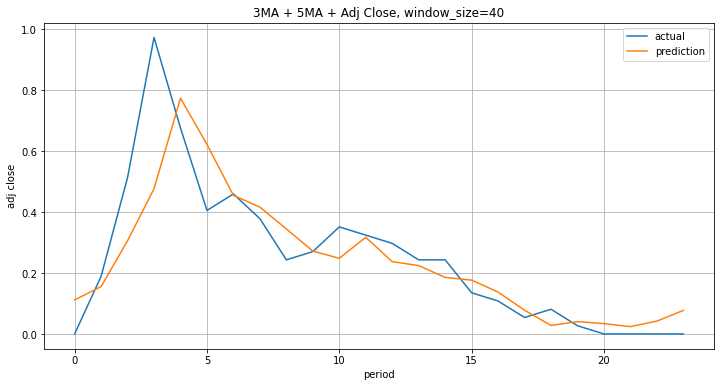

In [45]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()